# HyNet

In this notebook, we create a dataset of Armenian characters using the font Mk_Parz_U, and train a convolutional neural network to recognize characters from 56x56 images.

## Prepare

We build a dataset of Armenian characters based on the font Mk_Parz_U-Italic which resembles the one used in our target document :

![Document](test/samples/sample_denoised.png)

We use 56x56 pixel images and use filters and transformations to get a total of 34200 samples. We then split between train and test dataset with a ratio of 80/20.

In [10]:
import os
import pickle

from hynet.prepare import generate_classes, generate_dataset

N = 56  # 56x56 pixels
font_names = ["hynet/fonts/Mk_Parz_U-Italic"]
nb_classes = len(generate_classes())
train_dataset, test_dataset = generate_dataset(
    font_names=font_names, N=N, split_ratio=0.7
)

path = R"build/datasets/hynet"
os.makedirs(path, exist_ok=True)
with open(os.path.join(path, "train_dataset.pkl"), "wb") as f:
    pickle.dump(train_dataset, f)
with open(os.path.join(path, "test_dataset.pkl"), "wb") as f:
    pickle.dump(test_dataset, f)

2023-10-17 23:51:44,017 - root - INFO - Characters used     : ԱԲԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆ
2023-10-17 23:51:44,017 - root - INFO - Number of classes   : 76
2023-10-17 23:51:44,018 - root - INFO - Data augmentation   : 1 fonts, 20 rotations, 20 blur radiuses, 3 mode filters
2023-10-17 23:51:44,019 - root - INFO - Number of samples   : 91200


## Train

We train our LeNet-5 model to categorize the images into our 76 classes (alphabet with caps and small letters).

In [16]:
import os
import pickle

import torchvision.transforms as transforms
from hynet.model import LeNet, initialize_weights
from hynet.train import train
from torch.utils.data import DataLoader

batch_size = 16
nb_epochs = 10
learning_rate = 3.0e-4
steplr_step_size = 20
early_stopping_patience = 3

path = R"build/datasets/hynet"

train_dataset = pickle.load(open(os.path.join(path, "train_dataset.pkl"), "rb"))
train_data = next(iter(train_dataset))
mean, std = train_data[0].mean(), train_data[0].std()
test_dataset = pickle.load(open(os.path.join(path, "test_dataset.pkl"), "rb"))
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

# Initialize model
model_name = "LeNet-5"
model = LeNet(N=N, C=int(nb_classes), mean=mean, std=mean)
model.apply(initialize_weights)

# Train
report = train(
    model_name=model_name,
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    nb_classes=int(nb_classes),
    batch_size=batch_size,
    nb_epochs=nb_epochs,
    init_learning_rate=learning_rate,
    steplr_step_size=steplr_step_size,
    early_stopping_patience=early_stopping_patience,
)

2023-10-17 23:54:28,086 - root - INFO - Epoch = 0 / 10, Training Loss = 0.22, Test Loss = 0.21, Test Accuracy = 94.72%
2023-10-17 23:55:07,129 - root - INFO - Epoch = 1 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 98.72%
2023-10-17 23:55:46,559 - root - INFO - Epoch = 2 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 98.72%
2023-10-17 23:56:25,396 - root - INFO - Epoch = 3 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 98.72%
2023-10-17 23:57:05,914 - root - INFO - Epoch = 4 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 98.72%
2023-10-17 23:57:45,468 - root - INFO - Early stopping at epoch 5


In [17]:
nb_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nb of model parameters : {nb_parameters}")

Nb of model parameters : 251636


## Export

We export our trained model to various targets.

<Axes: title={'center': 'Training report'}, xlabel='epoch'>

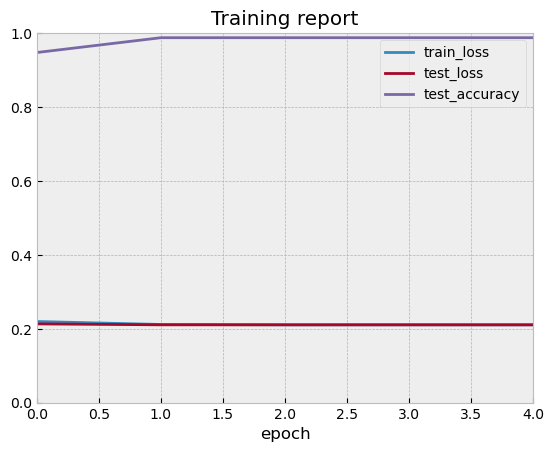

In [42]:
train_folder = "build/logs/train"
os.makedirs(train_folder, exist_ok=True)
report.save_model(os.path.join(train_folder, "model.pt"))  # save model
report.to_png(os.path.join(train_folder, "report.svg"))  # plot report as png
report.to_gif(os.path.join(train_folder, "report.gif"))  # plot report as gif
report.to_csv(os.path.join(train_folder, "report.csv"))  # export full report
report.plot()

## Evaluation

We evaluate our model on the first batch and then show miscategorized samples.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hynet.prepare import generate_classes
from PIL import Image, ImageFont

nb_batches = 10

df = report.dataframe
classes = generate_classes()

records = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for j, (T, label) in enumerate(zip(inputs, labels)):
            prediction = classes[predicted[j].item()]
            expected = classes[label.item()]
            if prediction != expected:
                records.append({"prediction": prediction, "expected": expected})
result = pd.DataFrame(records)

In [20]:
# Print most frequent miscategorized labels
result.apply(lambda x: f"{x['prediction']} => {x['expected']}", axis=1).value_counts()

ը => ր    851
Name: count, dtype: int64

In [47]:
from hynet.prepare import generate_character_image, generate_classes

font_name = "Mk_Parz_U"
# font_name = "Mk_Parz_U-Italic"
# font_name = "arial"
# font_name = "Arm Hmk's Bebas Neue"
font = ImageFont.truetype(f"./hynet/fonts/{font_name}.ttf", N)
records = []
with torch.no_grad():
    for character in classes:
        T = generate_character_image(character, font, N)
        outputs = model(T.view(1, 1, N, N))
        predictions = {
            classes[i]: prediction for (i, prediction) in enumerate(outputs[0])
        }
        for predicted_character, probability in predictions.items():
            records.append(
                {
                    "character": character,
                    "predicted_character": predicted_character,
                    "probability": probability.item(),
                }
            )
df = pd.DataFrame.from_records(records)

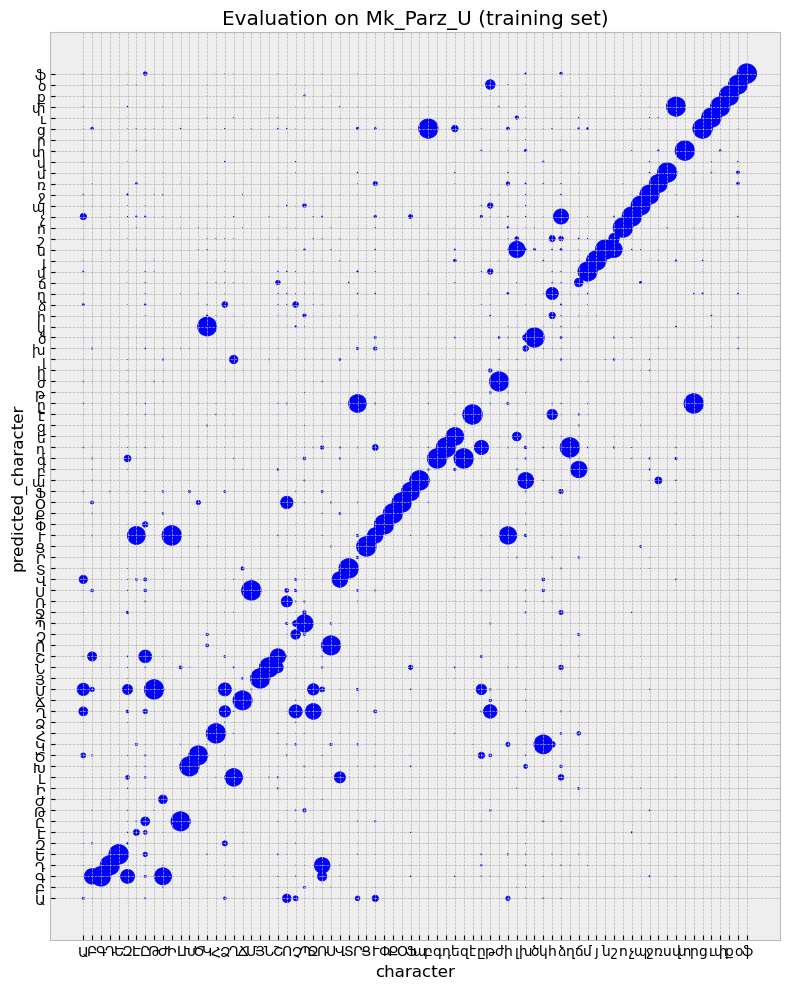

In [51]:
import matplotlib.style as style

style.use("bmh")
fig, ax = plt.subplots(figsize=(8, 10))
df.plot.scatter(
    x="character",
    y="predicted_character",
    s=df["probability"] * 200,
    ax=ax,
    title=f"Evaluation on {font_name} (training set)",
)
plt.tight_layout()
plt.savefig(
    Rf"C:\Users\Romain\OneDrive\Documents\Repos\v4nn4.github.io\assets\images\evaluation_{font_name}.png"
)